# Combining snowfall detection procedure and snow compaction/temperature models

This notebook uses and combines the preliminary work done previously to see if models and procedures developed so far are consistent with observations.

We detect snow accumulation and erosion events, build layers accordingly, simulate their evolution and plot our results against the snow-depth curve obtained from the lidar.

### Imports

In [1]:
import xarray as xr
import dask.array
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy import f2py
import pandas as pd

In [2]:
# Fortran codes imports

import ddensity
import snowtemp

### Functions definition

In [3]:
def fill_in_missing_variables(ds, var_to_copy):
    '''
    Function to artificially add 'snow_surface' variable in dataset
    Args:
        ds: clean data dataset
        var_to_copy: string, name of variable to be copied into a 'mean' variable
    Returns:
    '''
    ds['mean'] = ds[var_to_copy]


In [4]:
def median_space_filtering(ds, min_periods_val, x_span=11, y_span=11):
    '''
    Function to apply median filtering in space
    Args:
        ds: clean data dataset
        x_span: x-span on which to apply filtering, unit [index]
        y_span: y-span on which to apply filtering, unit [index]
    Returns:
    '''
    ds['snow_surface'] = ds['mean'].rolling({'x': x_span, 'y': y_span}, min_periods=min_periods_val, center=True).median()
    print(f'---> Median filtering in space with a window [{x_span}, {y_span}]')
    
    # note that a skipna argument is available (useful?) in xarray.DataArray.median()


In [5]:
def median_time_filtering(ds, min_periods_val, time_window=11):
    '''
    Function to apply median filtering in time
    Args:
        ds: clean data dataset
        time_window: time windo on which to apply median filter [index]
    Returns:
    '''
    ds['snow_surface'] = ds['snow_surface'].rolling(time=time_window, min_periods=min_periods_val, center=True).median()
    print(f'---> Median filtering in time with a window of {time_window}')
    
    # note that a skipna argument is available (useful?) in xarray.DataArray.median()


In [6]:
def get_snow_events(ds, x_sel, y_sel, time_window_std, std_threshold):
    '''
    Function that computes the dates of start and end times of snow events (snow accumulation and erosion)
    The events are defined as periods during which the snow-depth rolling standard deviation is higher than 
    a given threshold (set to 0.02 here)
    We distinguish between accumulation and erosion of snow by looking at the snow depth before and after the event
    Args:
        ds: clean dataset with 'snow_surface' variable
        x_sel: x coordinate of the point of interest (index)
        y_sel: y coordinate of the point of interest (index)
        time_window_std: size of the rolling window to compute standard deviation
        std_threshold: standard deviation threshold above which the curve is considered to have strong variations > snow event
    Returns:
        start_accumulation_indices: list of time indices corresponding to the start of an accumulation event
        start_erosion_indices: list of time indices corresponding to the end of an accumulation event
        end_accumulation_indices: list of time indices corresponding to the start of an erosion event
        end_erosion_indices: list of time indices corresponding to the end of an erosion event
    '''
    
    stdev = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values
    
    snow_events_occurrences = stdev > std_threshold   # booleans
    snow_events_occurrences = np.diff(snow_events_occurrences.astype(int))   # 1 or 0
    start_time_indices = np.where(snow_events_occurrences==1)[0]
    end_time_indices = np.where(snow_events_occurrences==-1)[0]
    
    start_accumulation_indices = []
    start_erosion_indices = []
    end_accumulation_indices = []
    end_erosion_indices = []
    
    for index in range(len(start_time_indices)):
        
        start_date = start_time_indices[index]
        end_date = end_time_indices[index]
    
        start_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=start_date))
        end_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=end_date))
    
        if start_snow_height < end_snow_height:
            start_accumulation_indices.append(start_time_indices[index])
            end_accumulation_indices.append(end_time_indices[index])
        else:
            start_erosion_indices.append(start_time_indices[index])
            end_erosion_indices.append(end_time_indices[index])
        
    return(start_accumulation_indices, start_erosion_indices, end_accumulation_indices, end_erosion_indices)


In [7]:
def get_change_in_snow_depth(ds, start_events, end_events, index_of_event, x_sel, y_sel):
    '''
    Function to get snow height difference (absolute value) before and after an event
    Args:
        ds: dataset containing the snow-depth data ('snow_surface' variable)
        start_events: list of time indices at which the events of interest (accumulation or erosion) started
        end_events: list of time indices at which the events of interest (accumulation or erosion) ended
        index_of_event: index of event of interest in the lists of time indices
        x_sel: index of the x-coordinate of the point of interest
        y_sel: index of the y-coordinate of the point of interest
    Returns:
        difference in snow-depth between the start and end of the event
    '''
    
    start_date = start_events[index_of_event]
    end_date = end_events[index_of_event]
    
    start_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=start_date))
    end_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=end_date))
    difference = abs(end_snow_height - start_snow_height)
    
    return(difference)

In [8]:
def simulate_snowpack_evolution(ds, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                start_accumulation, end_accumulation, start_erosion, end_erosion,
                                jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, gamma, cp_snow, melt_flag, a1, a2,
                                new_snow_ro=150, new_snow_temp=-5):
    '''
    Function that simulates the evolution of the snowpack over a certain period of time
    Args:
        ds: clean dataset
        x_sel: x-coordinate of the point of interest (index)
        y_sel: y-coordinate of the point of interest (index)
        nb_iterations: number of iterations
        
        end_accumulation_times: list of ending times of accumulations in seconds since data starting date
        end_erosion_times: list of ending times of erosions in seconds since data starting date
        start_accumulation: list of the indices of starting times of accumulations in ds
        end_accumulation: list of the indices of ending times of accumulations in ds
        start_erosion: list of the indices of starting times of erosions in ds
        end_erosion: list of the indices of ending times of erosions in ds
        
        jj: number of layers initially present                    # TODO add units and default values
        dt: timestep (s)
        ro_layer(1*max_nb_of_layers) array containing density value (kg per m**3) for each layer
        ro_water: density of water (kg per m**3)
        ro_ice: density of ice (kg per m**3)
        t_old: (1*max_nb_of_layers) array containing temperature value (degrees Celcius) for each layer
        tf: ice fusion temperature (degrees Celcius)
        tsfc: surface temperature (degrees Celcius)
        dy_snow: (1*max_nb_of_layers) array containing depth value (m) for each layer
        gamma: (1*max_nb_of_layers) array containing zeros
        cp_snow: thermal capacity of snow
        melt_flag: (1*max_nb_of_layers) array containing melt value (1 or 0) for each layer
        a1, a2: exponential parameters, empirically calibrated
        
        new_snow_ro: density of newly fallen snow in kg per m**3, default 150
        new_snow_temp: temperature of newly fallen snow in degrees celcius, default -5
    Returns:
        ro_layer_evolution: list of the states of layers' density through time, format [[ro_layer_1, ro_layer_2, ro_layer_3, ...]_time_1, [...]_time_2, [...], ...]
        depth_evolution: list of the states of layers' depth through time, format [[depth_layer_1, depth_layer_2, depth_layer_3, ...]_time_1, [...]_time_2, [...], ...]
        temperature_evolution: list of the states of layers' temperature through time, format [[temp_layer_1, temp_layer_2, temp_layer_3, ...]_time_1, [...]_time_2, [...], ...]
    '''
    # Initialize arrays to keep track of variables in time
    ro_layer_evolution = []
    depth_evolution = []
    temperature_evolution = []
    
    # Initialize indices of next accumulation/erosion events coming up (updated when their time is past)
    accumulation_index = 0
    erosion_index = 0
    
    for i in range(nb_iterations):
        if accumulation_index<len(end_accumulation_times) and i*dt>=end_accumulation_times[accumulation_index]:
            ddepth = get_change_in_snow_depth(ds, start_accumulation, end_accumulation, accumulation_index, x_sel, y_sel)
            ro_layer[jj] = new_snow_ro
            t_old[jj] = new_snow_temp
            dy_snow[jj] = ddepth
            if t_old[jj] <= 0:
                melt_flag[jj] = 0
            else:
                melt_flag[jj] = 1
            jj += 1
            accumulation_index += 1
    
        if erosion_index<len(end_erosion_times) and i*dt>=end_erosion_times[erosion_index]:
            ddepth = get_change_in_snow_depth(ds, start_erosion, end_erosion, erosion_index, x_sel, y_sel)
            erosion_index += 1
            if jj>0:
                if dy_snow[jj-1] > ddepth:
                    dy_snow[jj-1] = dy_snow[jj-1] - ddepth
                else:
                    jj -= 1
                    dy_snow[jj] = 0  # ??? TODO
                    ro_layer[jj] = 0  # ??? TODO
                    t_old[jj] = 0
                    melt_flag[jj] = 0
    
        # Update layers' parameters
        ro_layer, dy_snow = ddensity.ddensity_ml(ro_layer, tf, dt, ro_water, 
                                         ro_ice, t_old, jj, dy_snow, a1, a2)
        t_old = snowtemp.snowtemp_ml(gamma, t_old, tsfc, jj, dt, ro_layer, cp_snow, 
                                 tf, dy_snow, melt_flag)
    
        # Keep track of events
        ro_layer_evolution.append(ro_layer)
        depth_evolution.append(dy_snow)
        temperature_evolution.append(t_old)
        
    return(ro_layer_evolution, depth_evolution, temperature_evolution)

In [24]:
def simulate_snowpack_evolution_artif(ds, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                start_accumulation, end_accumulation, start_erosion, end_erosion,
                                jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, gamma, cp_snow, melt_flag, a1, a2,
                                new_snow_ro=150, new_snow_temp=-5):
    '''
    Function that simulates the evolution of the snowpack over a certain period of time,
    adjusting the height of layers artificially to match lidar curve
    Args:
        ds: clean dataset
        x_sel: x-coordinate of the point of interest (index)
        y_sel: y-coordinate of the point of interest (index)
        nb_iterations: number of iterations
        
        end_accumulation_times: list of ending times of accumulations in seconds since data starting date
        end_erosion_times: list of ending times of erosions in seconds since data starting date
        start_accumulation: list of the indices of starting times of accumulations in ds
        end_accumulation: list of the indices of ending times of accumulations in ds
        start_erosion: list of the indices of starting times of erosions in ds
        end_erosion: list of the indices of ending times of erosions in ds
        
        jj: number of layers initially present                    # TODO add units and default values
        dt: timestep (s)
        ro_layer(1*max_nb_of_layers) array containing density value (kg per m**3) for each layer
        ro_water: density of water (kg per m**3)
        ro_ice: density of ice (kg per m**3)
        t_old: (1*max_nb_of_layers) array containing temperature value (degrees Celcius) for each layer
        tf: ice fusion temperature (degrees Celcius)
        tsfc: surface temperature (degrees Celcius)
        dy_snow: (1*max_nb_of_layers) array containing depth value (m) for each layer
        gamma: (1*max_nb_of_layers) array containing zeros
        cp_snow: thermal capacity of snow
        melt_flag: (1*max_nb_of_layers) array containing melt value (1 or 0) for each layer
        a1, a2: exponential parameters, empirically calibrated
        
        new_snow_ro: density of newly fallen snow in kg per m**3, default 150
        new_snow_temp: temperature of newly fallen snow in degrees celcius, default -5
    Returns:
        ro_layer_evolution: list of the states of layers' density through time, format [[ro_layer_1, ro_layer_2, ro_layer_3, ...]_time_1, [...]_time_2, [...], ...]
        depth_evolution: list of the states of layers' depth through time, format [[depth_layer_1, depth_layer_2, depth_layer_3, ...]_time_1, [...]_time_2, [...], ...]
        temperature_evolution: list of the states of layers' temperature through time, format [[temp_layer_1, temp_layer_2, temp_layer_3, ...]_time_1, [...]_time_2, [...], ...]
    '''
    # Initialize arrays to keep track of variables in time
    ro_layer_evolution = []
    depth_evolution = []
    temperature_evolution = []
    
    # Initialize indices of next accumulation/erosion events coming up (updated when their time is past)
    accumulation_index = 0
    erosion_index = 0
    
    for i in range(nb_iterations):
        if accumulation_index<len(end_accumulation_times) and i*dt>=end_accumulation_times[accumulation_index]:
            snow_depth_total = sum(dy_snow[i] for i in range(0,jj))
            ddepth = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation[accumulation_index])) - snow_depth_total
            ro_layer[jj] = new_snow_ro
            t_old[jj] = new_snow_temp
            dy_snow[jj] = ddepth
            if t_old[jj] <= 0:
                melt_flag[jj] = 0
            else:
                melt_flag[jj] = 1
            jj += 1
            accumulation_index += 1
    
        if erosion_index<len(end_erosion_times) and i*dt>=end_erosion_times[erosion_index]:
            ddepth = get_change_in_snow_depth(ds, start_erosion, end_erosion, erosion_index, x_sel, y_sel)
            erosion_index += 1
            if jj>0:
                if dy_snow[jj-1] > ddepth:
                    dy_snow[jj-1] = dy_snow[jj-1] - ddepth
                else:
                    jj -= 1
                    dy_snow[jj] = 0  # ??? TODO
                    ro_layer[jj] = 0  # ??? TODO
                    t_old[jj] = 0
                    melt_flag[jj] = 0
    
        # Update layers' parameters
        ro_layer, dy_snow = ddensity.ddensity_ml(ro_layer, tf, dt, ro_water, 
                                         ro_ice, t_old, jj, dy_snow, a1, a2)
        t_old = snowtemp.snowtemp_ml(gamma, t_old, tsfc, jj, dt, ro_layer, cp_snow, 
                                 tf, dy_snow, melt_flag)
    
        # Keep track of events
        ro_layer_evolution.append(ro_layer)
        depth_evolution.append(dy_snow)
        temperature_evolution.append(t_old)
        
    return(ro_layer_evolution, depth_evolution, temperature_evolution)

In [52]:
def plot_simul_and_signal(ds, x_sel, y_sel, depth_evolution, nb_layers_to_plot, data_start_date, dt, nb_iterations,
                          start_accumulation, end_accumulation, start_erosion, end_erosion,
                          my_title='Comparison between lidar-measured and simulated snow depth', save_file=False, my_file_name='my_fig.png', my_figsize=(15, 7)):
    '''
    Function to plot the simulated snowpack and lidar signal on the same plot
    Args:
        ds: clean dataset
        x_sel: x-coordinate of the point of interest
        y_sel: y-coordinate of the point of interest
        depth_evolution: list of the states of layers' depth through time, format [[depth_layer_1, depth_layer_2, depth_layer_3, ...]_time_1, [...]_time_2, [...], ...]
        nb_layers_to_plot: number of layers to plot
        data_start_date: first date of the dataset, pandas datetime format
        dt: timestep used in snowpack simulation
        nb_iterations: number of iterations used in snowpack simulation
        
        start_accumulation: list of the indices of starting times of accumulations in ds
        end_accumulation: list of the indices of ending times of accumulations in ds
        start_erosion: list of the indices of starting times of erosions in ds
        end_erosion: list of the indices of ending times of erosions in ds
        
        my_title: title of the figure, default 'Comparison between lidar-measured and simulated snow depth'
        save_file: boolean, default False
        my_file_name: name to be given to the saved file, default 'my_fig.png'
        my_figsize: figure size, default (15, 7)
    Returns:
    '''
    layers = np.zeros((nb_layers_to_plot, len(depth_evolution)))
    for i in range(len(depth_evolution)):
        layers[0][i] = depth_evolution[i][0]
    for layer_index in range(1, nb_layers_to_plot):
        for i in range(len(depth_evolution)):
            layers[layer_index][i] = depth_evolution[i][layer_index] + layers[layer_index-1][i]
    
    fig = plt.figure(figsize=(15, 7))
    times = pd.date_range(start=data_start_date,freq=str(dt)+'S',periods=nb_iterations)
    
    for layer_index in range(nb_layers_to_plot):
        plt.plot(times, layers[layer_index], label='layer '+str(layer_index+1))
        
    ds.isel(x=x_sel, y=y_sel).snow_surface.plot(c='k', alpha=0.2)

    ds.isel(x=x_sel, y=y_sel, time=start_accumulation).snow_surface.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.')
    ds.isel(x=x_sel, y=y_sel, time=end_accumulation).snow_surface.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.')
    ds.isel(x=x_sel, y=y_sel, time=start_erosion).snow_surface.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion')
    ds.isel(x=x_sel, y=y_sel, time=end_erosion).snow_surface.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion')
    
    plt.legend()
    plt.title('Comparison between lidar-measured and simulated snow depth')
    
    if save_file:
        fig.savefig(my_file_name)
    
    return()

### Define data

In [10]:
# Get data from files

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_dec_jan_feb_pit.nc')
data_dec_jan_feb = xr.open_dataset('data_dec_jan_feb_pit.nc')

# all_data = xr.open_mfdataset('/home/mabonnet/Desktop/data/2021_2022_livox_surfaces/*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# all_data.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_2021-2022.nc')
all_data_set = xr.open_dataset('data_2021-2022.nc')

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(84,106), y=slice(28,50)).to_netcdf('snow_pit_1.nc')
data_pit_1 = xr.open_dataset('snow_pit_1.nc')

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(105,127), y=slice(39,61)).to_netcdf('snow_pit_2.nc')
data_pit_2 = xr.open_dataset('snow_pit_2.nc')

In [11]:
# Define which dataset to use in what follows

data_set_used = all_data_set

In [12]:
# Pre-processing to get clean data

fill_in_missing_variables(data_set_used, 'surface')

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 11)
median_time_filtering(data_set_used, 11)

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].min() 


---> Median filtering in space with a window [11, 11]
---> Median filtering in time with a window of 11


### Define parameters

In [13]:
# Defining parameters for snow events detection

x_sel = 20
y_sel = 20
time_window_std = 25
std_threshold = 0.015

data_starting_date_in_ns = 1625149800000000000
# 1638796500000000000 is the first time point in data_dec_jan_feb
# 1625149800000000000 is the first time point in all_data_set (2021-07-01-16:30)
# 1638316800000000000 is the first time point in the snowpit datasets
# 1630454400000000000 is the first time point in Crocus

In [14]:
# Initial state for compaction/temperature model, with 0 layers

# Adaptable parameters
tsfc = -15
cp_snow = 2.1
dt = 100
a1 = 0.0013
a2 = 0.021

max_nb_of_layers = 20
nb_iterations = 200000     # TODO adapt to duration of data

# 'Fixed' parameters
tf = 0
ro_water = 1000
ro_ice = 910
jj = 0
ro_layer = np.zeros((max_nb_of_layers, 1))
t_old = np.zeros((max_nb_of_layers, 1))
dy_snow = np.zeros((max_nb_of_layers, 1))
gamma = np.zeros((max_nb_of_layers, 1))
melt_flag = np.zeros((max_nb_of_layers, 1))


### Get snow events timing

In [15]:

results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
start_accumulation = results[0]
start_erosion = results[1]
end_accumulation = results[2]
end_erosion = results[3]


/tmp/ipykernel_10260/140324894.py:20: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  stdev = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values


In [16]:
# Convert end times into more manageable orders of magnitude

end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s


### Simulate evolution of snowpack

In [25]:
# Update variables at each timepoint

ro_layer_evolution, depth_evolution, temperature_evolution = simulate_snowpack_evolution(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                                                                        start_accumulation, end_accumulation, start_erosion, end_erosion,
                                                                                        jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, gamma, cp_snow, melt_flag, a1, a2)

ro_layer_evolution_artif, depth_evolution_artif, temperature_evolution_artif = simulate_snowpack_evolution_artif(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                                                                        start_accumulation, end_accumulation, start_erosion, end_erosion,
                                                                                        jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, gamma, cp_snow, melt_flag, a1, a2)


### Plot evolution of snowpack, compare with lidar measurements

()

/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


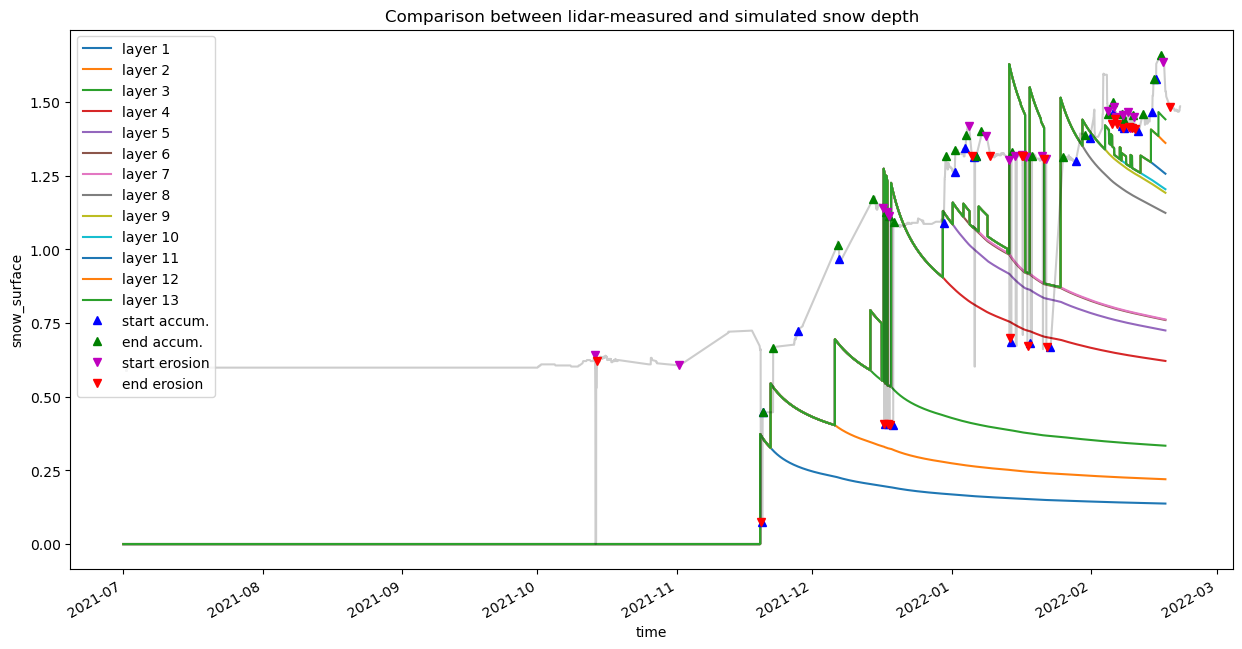

In [55]:
data_start_date = pd.to_datetime('2021-07-01T00:00')

plot_simul_and_signal(data_set_used, x_sel, y_sel, depth_evolution, 13, data_start_date, dt, nb_iterations,
                          start_accumulation, end_accumulation, start_erosion, end_erosion)

In [20]:
# Note on the above figure: if erosion and accumulation are quasi-simultaneous, they will not be taken into account (the timestamp is passed, so we add a layer, 
# and then delete it because the other timestamp is passed). If the erosion is smalle rthan the accumulation, the same thing happens but instead of deleting the layer we just added,
# we reduce it and thus create a small layer.

# The code does what we want it to correctly, even though looking at the curves may be confusing because we cannot see the discretization directly.


()

/home/mabonnet/miniconda3/envs/awk/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


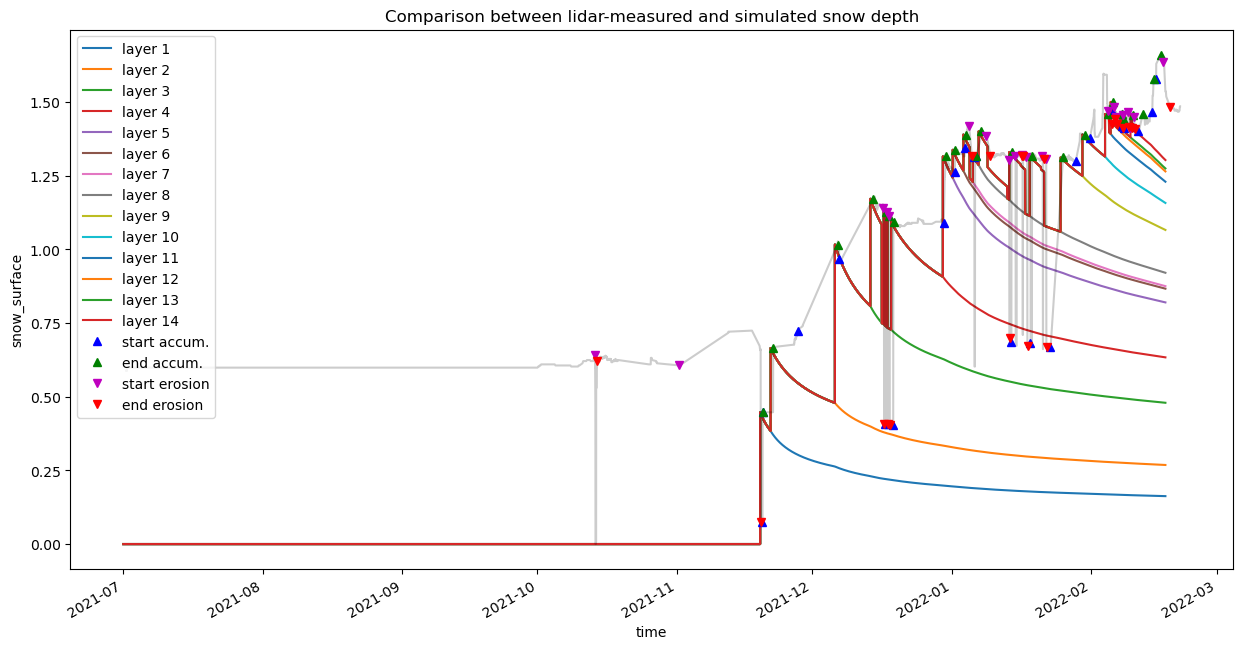

In [57]:
data_start_date = pd.to_datetime('2021-07-01T00:00')

plot_simul_and_signal(data_set_used, x_sel, y_sel, depth_evolution_artif, 14, data_start_date, dt, nb_iterations,
                          start_accumulation, end_accumulation, start_erosion, end_erosion)

#### Other plots, less interesting for now

Text(0, 0.5, 'Density')

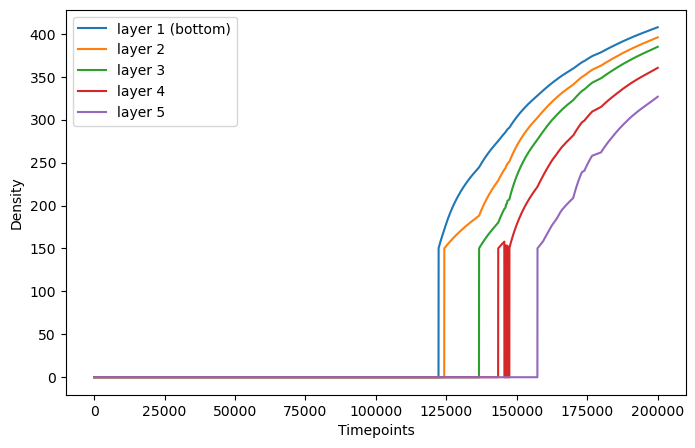

In [21]:
# Density

layer1 = [ro_layer_evolution[i][0] for i in range(len(ro_layer_evolution))]
layer2 = [ro_layer_evolution[i][1] for i in range(len(ro_layer_evolution))]
layer3 = [ro_layer_evolution[i][2] for i in range(len(ro_layer_evolution))]
layer4 = [ro_layer_evolution[i][3] for i in range(len(ro_layer_evolution))]
layer5 = [ro_layer_evolution[i][4] for i in range(len(ro_layer_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1 (bottom)')
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(layer4, label='layer 4')
plt.plot(layer5, label='layer 5')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Density')

NameError: name 'sum_layers' is not defined

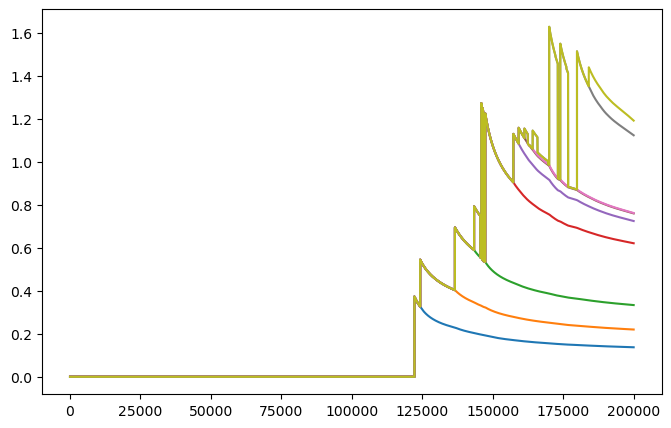

In [22]:
# Depth

layer1 = [depth_evolution[i][0] for i in range(len(depth_evolution))]
layer2 = [layer1[i] + depth_evolution[i][1] for i in range(len(depth_evolution))]
layer3 = [layer2[i] + depth_evolution[i][2] for i in range(len(depth_evolution))]
layer4 = [layer3[i] + depth_evolution[i][3] for i in range(len(depth_evolution))]
layer5 = [layer4[i] + depth_evolution[i][4] for i in range(len(depth_evolution))]
layer6 = [layer5[i] + depth_evolution[i][5] for i in range(len(depth_evolution))]
layer7 = [layer6[i] + depth_evolution[i][6] for i in range(len(depth_evolution))]
layer8 = [layer7[i] + depth_evolution[i][7] for i in range(len(depth_evolution))]
layer9 = [layer8[i] + depth_evolution[i][8] for i in range(len(depth_evolution))]
# sum_layers = [layer1[i] + layer2[i] + layer3[i] + layer4[i] + layer5[i] + layer6[i] + layer7[i] + layer8[i] + layer9[i] for i in range(len(depth_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1 (bottom)')
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(layer4, label='layer 4')
plt.plot(layer5, label='layer 5')
plt.plot(layer6, label='layer 6')
plt.plot(layer7, label='layer 7')
plt.plot(layer8, label='layer 8')
plt.plot(layer9, label='layer 9')
plt.plot(sum_layers, label='total depth')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Depth')

In [ ]:
plt.figure(figsize=(8, 5))

data_set_used.isel(x=x_sel, y=y_sel).snow_surface.plot(c='k', alpha=0.2)

data_set_used.isel(x=x_sel, y=y_sel, time=start_accumulation).snow_surface.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.')
data_set_used.isel(x=x_sel, y=y_sel, time=end_accumulation).snow_surface.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.')
data_set_used.isel(x=x_sel, y=y_sel, time=start_erosion).snow_surface.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion')
data_set_used.isel(x=x_sel, y=y_sel, time=end_erosion).snow_surface.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion')

simulated_times = [(i*dt + 1638796500000000000) * 1000000000]
# plt.plot(simulated_times, sum_layers, label='simulated snow depth')   # TODO

plt.legend()


In [ ]:
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(18, 10))

ax[0].plot(layer1, label='layer 1')
ax[0].plot(layer2, label='layer 2')
ax[0].plot(layer3, label='layer 3')
ax[0].plot(layer4, label='layer 4')
ax[0].plot(layer5, label='layer 5')
ax[0].plot(layer6, label='layer 6')
ax[0].plot(layer7, label='layer 7')
ax[0].plot(layer8, label='layer 8')
ax[0].plot(layer9, label='layer 9')
ax[0].plot(layer10, label='layer 10')
ax[0].plot(layer11, label='layer 11')
ax[0].plot(layer12, label='layer 12')

ax[0].set_ylabel('simulated snow depth')

data_set_used.isel(x=x_sel, y=y_sel).snow_surface.plot(c='k', alpha=0.2, ax=ax[1])

data_set_used.isel(x=x_sel, y=y_sel, time=start_accumulation).snow_surface.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.', ax=ax[1])
data_set_used.isel(x=x_sel, y=y_sel, time=end_accumulation).snow_surface.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.', ax=ax[1])
data_set_used.isel(x=x_sel, y=y_sel, time=start_erosion).snow_surface.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion', ax=ax[1])
data_set_used.isel(x=x_sel, y=y_sel, time=end_erosion).snow_surface.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion', ax=ax[1])
ax[1].legend()

ax[0].set_title('Comparison between lidar-measured and simulated snow depth')

# fig.savefig('measured_vs_simul_snow_depth.png')

In [ ]:
# Temperature

layer1 = [temperature_evolution[i][0] for i in range(len(temperature_evolution))]
layer2 = [temperature_evolution[i][1] for i in range(len(temperature_evolution))]
layer3 = [temperature_evolution[i][2] for i in range(len(temperature_evolution))]
layer4 = [temperature_evolution[i][3] for i in range(len(temperature_evolution))]
layer5 = [temperature_evolution[i][4] for i in range(len(temperature_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1 (bottom)')
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(layer4, label='layer 4')
plt.plot(layer5, label='layer 5')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Temperature')

In [ ]:
# TODO pas de temps sont trop grands pour temperature ?